# Hastings thresholding algorithm for max cut

https://arxiv.org/pdf/1905.07047.pdf

Algorithm works on D-regular triangle free graphs with N nodes total:
* Randomly assign each spin to a node.
* Then, for each spin, if sufficiently many neighbors have same spin (i.e. in same partition), then flip spin.
* Optimize this threshold for each D, and it almost always outperforms QAOA


Performance $\delta$ is determined by number of edges $K$ where ends have different spins (i.e. across partitions). 
$$
K = (1/2 + \delta)M
$$
* $M=DN/2$ is total number of edges.
*  $\delta$ can be considered "improvement" over randomly assigning points.
* Both QAOA and threshold algorithm have the scaling $\delta \propto D^{-0.5}$.

## Goal 1: Reproduce the max cut algorithm in the paper.

July 7  2020-- finally figured out the way to do this.


Hastings has a neat formalism, given the subgraph of edge $E_{ij}$ and all other neighbors of $i$ and $j$:
* $q(k)$ is function to switch or stay. Initially, it's -1 if k >= threshold, +1 otherwise.
* $P_n(k)$ is the binomial probability distribution ${n \choose k}2^{-n}$ for $n$ neighbors not including j (initially, this is $n=d-1$)

By computing the correlation function $<Z_i Z_j>$, you find the likelihood the two nodes will be in the same partition (=+1) or opposite partition (=-1).

For triangle-free graphs, they either agree $q(k+1)$ or disagree $q(k)$, summing over possible combinations of other neighbors. Both terms are squared because the graph is identical for $i$ and $j$:
$$
<Z_i Z_j> = 1/2 (\sum_{k=0}^{d-1} P_{d-1}(k) q(k+1))^2 - 1/2 (\sum_{k=0}^{d-1} P_{d-1}(k) q(k))^2
$$

### Code to implement this

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

In [2]:
def qsimple(k, threshold):
    return -1 if k >= threshold else 1

def q(k, threshold):
    """q(k) from above, but also works for numpy arrays"""
    return (1-(k >= threshold)*2)

In [3]:
def test_qs():
    """Test q and qsimple methods"""
    assert q(2, 3) ==  1 == qsimple(2, 3), "testing q less than threshold"
    assert q(3, 3) == -1 == qsimple(3, 3), "testing q equal to threshold"
    assert q(3, 2) == -1 == qsimple(3, 2), "testing q higher than threshold"
    assert np.all(q(np.array([2,3,4]), 3) == np.array([1, -1, -1])), "list of q"
    assert np.all(q(np.array([2,3,4]), 3) == [qsimple(2, 3), qsimple(3,3), qsimple(4,3)]), "list of q"
    
test_qs()

In [8]:
def calc_improvement(D, T):
    """
    This calculates the improvement over random after 1 step of Hastings' thresholding algorithm. 
    Precisely, returns delta = -1/2 <Z_i Z_j> for D-regular graphs with threshold T.
    """
    s1 = 0
    s2 = 0
    # go through # of agreeing neighbors, from 0 through D-1
    for i in range(D):
        # factor out two copies of 2^-n, n=D-1
        s1 += binom(D-1, i)*q(i+1, T)
        s2 += binom(D-1, i)*q(i, T)
    return -0.5 * 0.5 * (s1**2 - s2**2) * 2**(-2*(D-1))

In [5]:
def test_all_thresholds(D, fn):
    """
    Gets improvement over random for all possible thresholds (from 0 through D+1).
    Returns all results.
    """
    return [fn(D, T) for T in range(D+2)]

def print_max(D, results):
    """Finds and prints out the maximum improvement in the input list."""
    print("D =", D, "T =", results.index(max(results)), "improvement =", max(results))
    
def plot_by_T(D, results):
    plt.plot(range(len(results)), results)
    plt.xlabel("min threshold to switch")
    plt.ylabel("improvement $\delta$")

### Plots
This plots improvement by chosen threshold. The maximum value should match Table 1 in Hastings' paper.

D = 2 T = 2 improvement = 0.25
D = 3 T = 3 improvement = 0.1875
D = 4 T = 3 improvement = 0.140625
D = 5 T = 4 improvement = 0.15625
D = 6 T = 5 improvement = 0.1220703125
D = 7 T = 5 improvement = 0.128173828125
D = 8 T = 6 improvement = 0.11663818359375
D = 9 T = 6 improvement = 0.107666015625
D = 10 T = 7 improvement = 0.107666015625
D = 11 T = 7 improvement = 0.09252548217773438


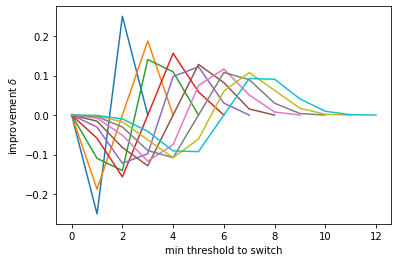

In [105]:
for D in range(2, 12):
    results = test_all_thresholds(D, calc_improvement)
    print_max(D, results)
    plot_by_T(D, results)

## Goal 2: Extend this max cut algorithm admitting triangles

July 7 -- figured out how to do this

### One triangle

When you have one triangle, $i$ can agree or disagree with $j$ and with the shared node. There are four cases:

$$
<Z_i Z_j> = 1/4 (\sum_{k=0}^{d-2} P_{d-2}(k) q(k+2))^2 + 1/4 (\sum_{k=0}^{d-2} P_{d-2}(k) q(k+1))^2 - 1/2 (\sum_{k=0}^{d-2} P_{d-2}(k) q(k))(\sum_{k=0}^{d-2} P_{d-2}(k) q(k+1))
$$

In [9]:
def calc_improvement_one_triangle(D, T):
    """
    This calculates the improvement over random 
    after 1 step of Hastings' thresholding algorithm on a subgraph including 1 triangle.
    Precisely, returns delta = -1/2 <Z_i Z_j> for D-regular graphs with threshold T.
    """
    s1 = 0
    s2 = 0
    s3 = 0
    # go through # of agreeing neighbors, from 0 through D-2
    for i in range(D-1):
        # factor out two copies of 2^-n, n=D-2
        s1 += binom(D-2, i)*q(i+2, T)
        s2 += binom(D-2, i)*q(i+1, T)
        s3 += binom(D-2, i)*q(i, T)
    return -0.5 * 0.25 * (s1**2 + s2**2 - 2*s2*s3) * 2**(-2*(D-2))

### Plots (one triangle vs triangle-free)

Notice that the maximum improvement is slightly reduced when adding one triangle. Perhaps it is because $j$ is slightly more likely to be "in sync" with $i$; i.e. they will both switch if they share many neighbors.

It is also interesting that switching at a small threshold (i.e. less than 1/2 of neighbors) will make the max cut even smaller! (Why?)

D = 6 T = 5 improvement = 0.1220703125
D = 6 T = 5 improvement = 0.10546875


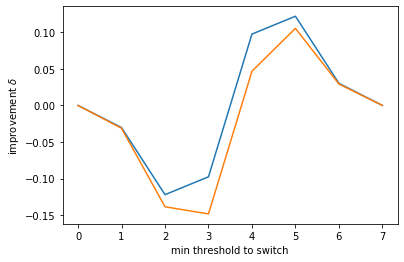

In [106]:
D=6
for results in [test_all_thresholds(D, calc_improvement), 
                test_all_thresholds(D, calc_improvement_one_triangle)]:
    print_max(D, results)
    plot_by_T(D, results)

### N triangles

You can describe this generally, by looking at cases where $i$ and $j$ agree or disagree, and when $0\le l \le N$ of the shared nodes agree with $i$.

This formula captures the N=0 and N=1 cases.

$$
<Z_i Z_j> = \sum_{l=0}^N 1/2 P_N(l) f(D, N, l) \\
f(D, N, l) = \big( \sum_{k=0}^{D-1-N} P_{D-1-N}(k) q(k+l+1) \big)^2  
-  \big( \sum_{k=0}^{D-1-N} P_{D-1-N}(k) q(k+l) \big)\big( \sum_{k=0}^{D-1-N} P_{D-1-N}(k) q(k+N-l) \big )
$$

In [23]:
def calc_improvement_n_triangles(D, T, N):
    """
    This calculates the improvement over random 
    after 1 step of Hastings' thresholding algorithm on a subgraph including N triangles.
    Precisely, returns delta = -1/2 <Z_i Z_j> for D-regular graphs with threshold T.
    """
    p_k_vec = binom(D-1-N, range(D-N))
    out = 0
    for l in range(0, N+1):
        q_kl1_vec = q(np.array(range(l+1, D-N + l+1)), T)
        q_kl_vec = q(np.array(range(l, D-N + l)), T)
        q_knl_vec = q(np.array(range(N-l, D-N + N-l)), T)
        f_dnl = sum(p_k_vec * q_kl1_vec)**2 - sum(p_k_vec * q_kl_vec)*sum(p_k_vec * q_knl_vec)
        out += (f_dnl*binom(N, l))
    # add powers of 2 at the end
    return -0.5 * 0.5 * out * 2**(-N) * 2**((-2*(D-1-N)))

In [25]:
def test_n_triangles_formula():
    """Tests n triangle formula against 0 and 1 triangle formula."""
    assert calc_improvement(5, 2) == calc_improvement_n_triangles(5, 2, 0)
    assert calc_improvement(5, 5) == calc_improvement_n_triangles(5, 5, 0)
    assert calc_improvement_one_triangle(5, 2) == calc_improvement_n_triangles(5, 2, 1)

test_n_triangles_formula()

In [26]:
def calc_improvement_n_triangles_curried(N):
    """Creates a 2-argument function given number of triangles N."""
    return lambda d, t: calc_improvement_n_triangles(d, t, N)

### Plots (triangle-free vs many triangles)

#### sanity check (triangle-free)


D = 4 T = 3 improvement = 0.140625
D = 4 T = 3 improvement = 0.140625


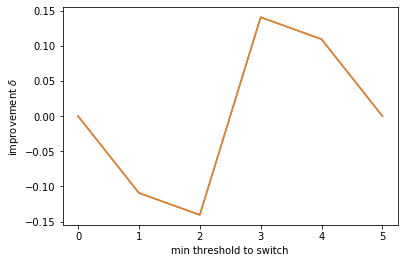

In [30]:
D=4
for results in [test_all_thresholds(D, calc_improvement), 
                test_all_thresholds(D, calc_improvement_n_triangles_curried(0))]:
    print_max(D, results)
    plot_by_T(D, results)

#### sanity check (one triangle)


D = 7 T = 5 improvement = 0.09765625
D = 7 T = 5 improvement = 0.09765625


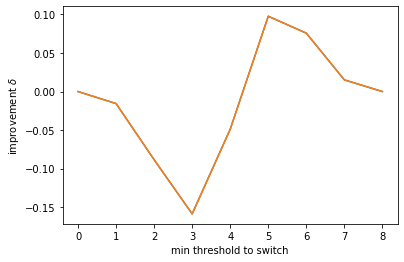

In [34]:
D=7
for results in [test_all_thresholds(D, calc_improvement_one_triangle), 
                test_all_thresholds(D, calc_improvement_n_triangles_curried(1))]:
    print_max(D, results)
    plot_by_T(D, results)

#### comparing different #s of triangles

The more triangles shared by $i$ and $j$, the worse the improvement is. It makes sense, since the spin choice of $i$ and $j$ are influenced more by the shared nodes'perspective than by the edge $E_{ij}$.

D = 7 T = 5 improvement = 0.128173828125
D = 7 T = 5 improvement = 0.09765625
D = 7 T = 5 improvement = 0.068359375
D = 7 T = 6 improvement = 0.056640625
D = 7 T = 6 improvement = 0.04296875
D = 7 T = 6 improvement = 0.0234375
D = 7 T = 0 improvement = -0.0


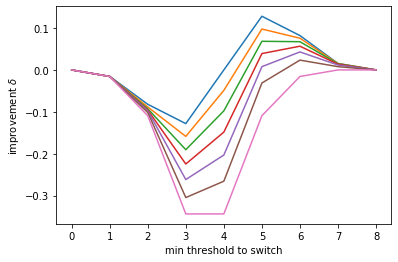

In [45]:
D=7
# from 0 through D-1 possible triangles
ns_to_plot = range(D)

for results in [test_all_thresholds(D, calc_improvement_n_triangles_curried(n)) for n in ns_to_plot]:
    print_max(D, results)
    plot_by_T(D, results)
    # Todo add legend

#### maximum improvement by D, N

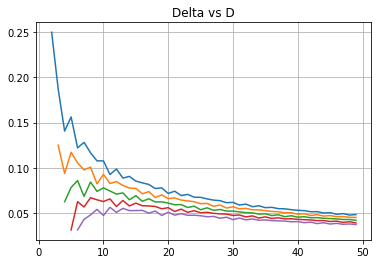

In [115]:
for n in range(5):
    ds = range(2+n, 50)
    fn = calc_improvement_n_triangles_curried(n)
    deltas = [max(test_all_thresholds(d, fn)) for d in ds]
    plt.plot(ds, deltas)
plt.title("Delta vs D")
plt.grid(True)

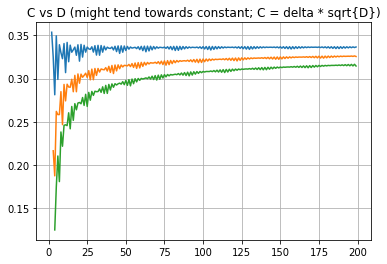

In [122]:
# looks like scaling is different when there are triangles!
for n in range(3):
    ds = range(2+n, 200)
    fn = calc_improvement_n_triangles_curried(n)
    cs = [d**0.5*max(test_all_thresholds(d, fn)) for d in ds]
    plt.plot(ds, cs)
plt.title("C vs D (might tend towards constant; C = delta * sqrt{D})")
plt.grid(True)

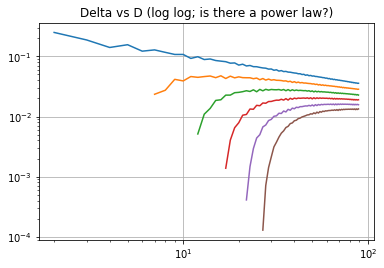

In [114]:
for n in range(0, 30, 5):
    ds = range(2+n, 90)
    fn = calc_improvement_n_triangles_curried(n)
    deltas = [max(test_all_thresholds(d, fn)) for d in ds]
    plt.loglog(ds, deltas)
plt.title("Delta vs D (log log; is there a power law?)")
plt.grid(True)

## Goal 3: Compare max cut algorithm on non-triangle-free graphs with QAOA
* see QAOA.ipynb for the analysis extending QAOA.
* need to see if I can do better than what I have to optimize QAOA angles.
* need to compare the two results, at least for small D (can graph together.)

## Goal 4: Extend max cut algorithm to p=2
* start with triangle-free graphs
* will need to find a reference for QAOA

## Goal 5: Modify Hastings thresholding algorithm to do better with triangles.
* What if you only looked at neighbors that weren't shared with other nodes?